In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from energy_model import *
from eia_codes import eia_codes 
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('energy_balance/energy_balance_plant_6011.csv', parse_dates=True, index_col='date')
df.head(2)

,Plant ID,diversion_rate_kgM,withdrawal_rate_kgM,discharge_rate_kgM,consumption_rate_kgM,avg_intake_temp_C,max_intake_temp_C,avg_discharge_temp_C,max_discharge_temp_C,Nameplate Capacity (MW),max_withdrawal_rate_kgM,elc_mmbtu_in,elc_mwh_out,elc_in_kj,elc_out_kj,modeled_discharge_temp,R_combined,temp_limit
date,,,,,,,,,,,,,,,,,,
2016-01-31,6011.0,0.0,4.015153e+11,4.015153e+11,0.0,7.777778,12.222222,13.333333,65.0,1850.4,4.028900e+11,13356140.0,1277060.0,1.409206e+13,4.597416e+12,13.433608,0.0,32.0
2016-02-29,6011.0,0.0,2.938745e+11,2.938745e+11,0.0,4.444444,6.666667,5.000000,55.0,1850.4,3.768971e+11,9472394.0,905712.0,9.994320e+12,3.260563e+12,9.924884,0.0,32.0


In [3]:
df.max_intake_temp_C.max()

31.111111111111114

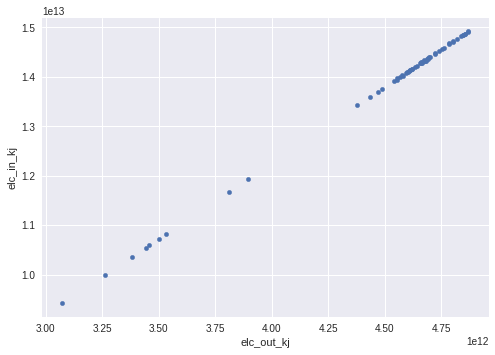

In [4]:
ax = df.plot.scatter(x='elc_out_kj', y='elc_in_kj')

In [5]:
print(df.elc_out_kj.max(), df.elc_in_kj.max())

4870501200000.0 14916037631887.455


In [6]:
capacity = df['Nameplate Capacity (MW)'].values[0]
max_output_kj = mwh_to_kj(capacity*31*24)
temp_limit = 32
R = 0
T_in = 31.1
T_out = 32
max_flow = df['max_withdrawal_rate_kgM'].values[0]

In [7]:
model = linear_fit(df[['elc_out_kj','elc_in_kj']])
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              elc_in_kj   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.277e+06
Date:                Wed, 23 Mar 2022   Prob (F-statistic):          1.18e-127
Time:                        09:52:44   Log-Likelihood:                -1462.0
No. Observations:                  60   AIC:                             2928.
Df Residuals:                      58   BIC:                             2932.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.762e+09   1.22e+10      0.226      0.8

In [8]:
Xnew = sm.add_constant([1,max_output_kj])

In [9]:
ypred = model.predict(Xnew)[1]

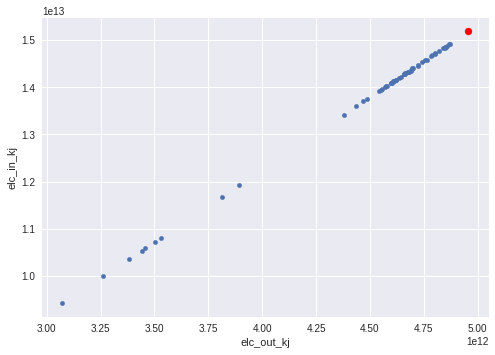

In [10]:
ax = df.plot.scatter(x='elc_out_kj', y='elc_in_kj')
ax.scatter(max_output_kj, ypred, color='r')

In [11]:
calculate_max_flow_rate(R, ypred, max_output_kj, T_in, T_out)

2717488058317.662

In [12]:
max_flow

402889953499.776

In [13]:
calculate_power(R, df.elc_in_kj.max(), max_flow, T_in, T_out)

13400003025863.15

In [14]:
max_output_kj

4956111360000.0

In [15]:
def calculate_deltaE(Rc,
                     W_in,
                     T_in,
                     T_out):

    deltaE = ((C_w*W_in*(T_out-T_in))/(1-Rc))

    return deltaE

In [16]:
calculate_deltaE(R, max_flow, T_in, T_out)

1516034606024.3047

In [17]:
print( df.elc_in_kj.max()-df.elc_out_kj.max())

10045536431887.455


In [18]:
calculate_discharge_temp(Rc=R, 
                         E_in=ypred, 
                         E_out=max_output_kj, 
                         T_in=T_in, 
                         w_in=max_flow, 
                         w_out=max_flow)

37.17048954991441

In [19]:
calculate_discharge_temp(Rc=R, 
                         E_in=ypred*0.1, 
                         E_out=max_output_kj*0.1, 
                         T_in=T_in, 
                         w_in=max_flow, 
                         w_out=max_flow)

31.707048954991443

In [21]:
files = glob.glob('energy_balance/**.csv')

NineMilePointNuclearStation


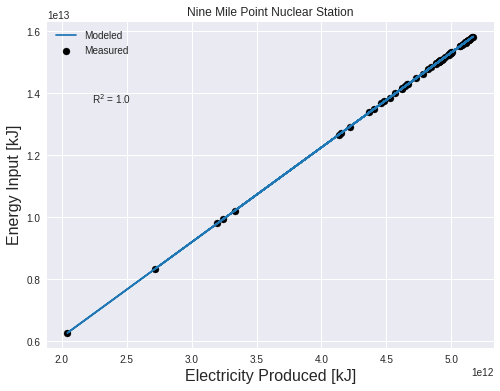

Oconee


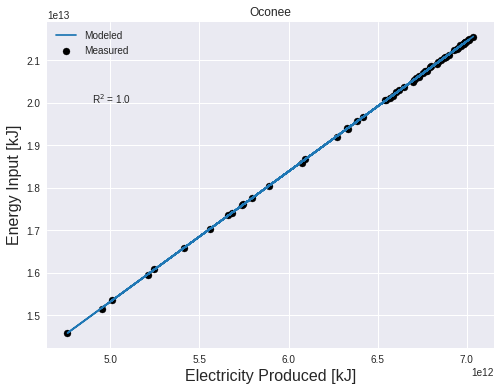

DonaldCCook


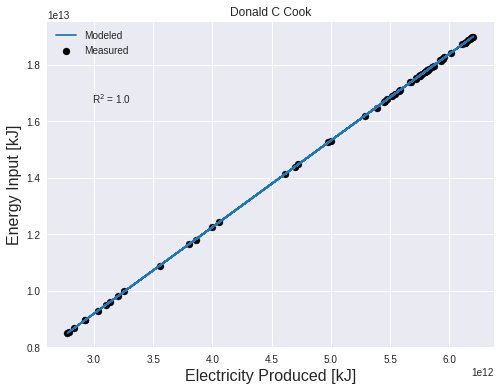

PointBeachNuclearPlant


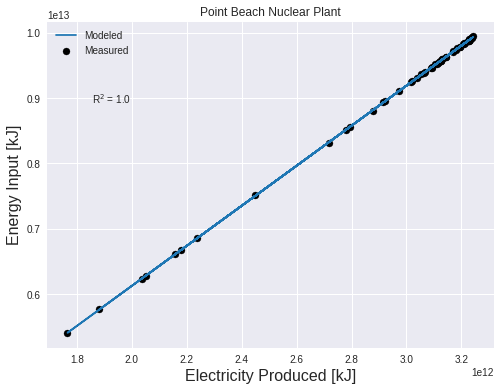

BrownsFerry


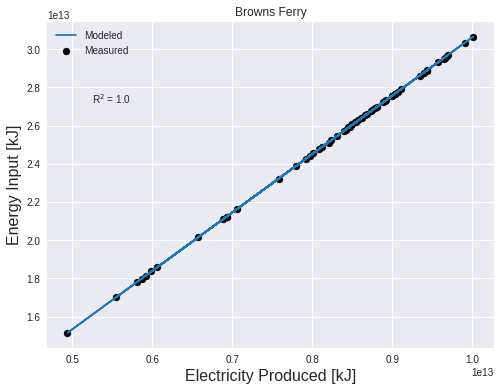

CooperNuclearStation


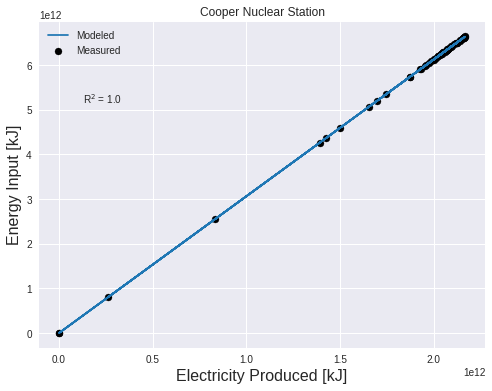

Surry


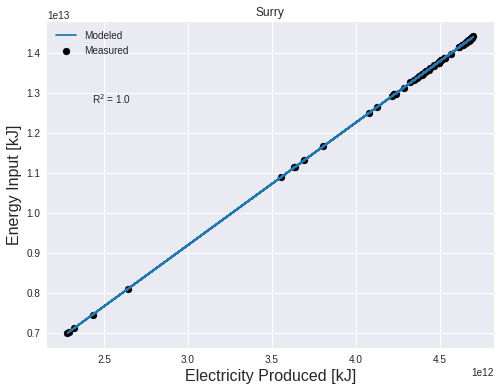

StLucie


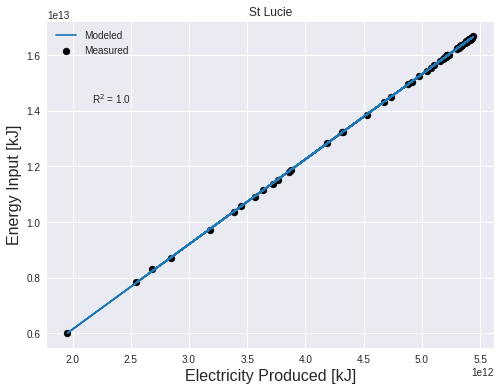

QuadCitiesGeneratingStation


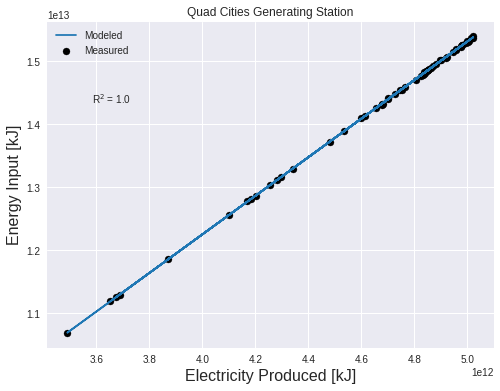

DiabloCanyon


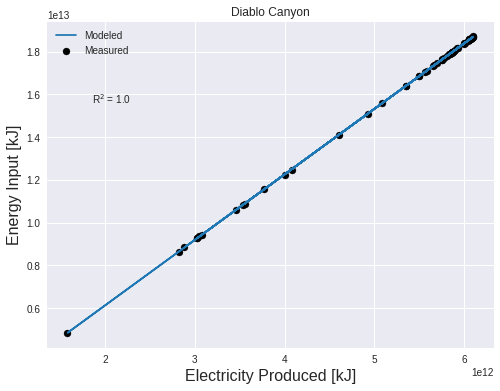

JamesAFitzpatrick


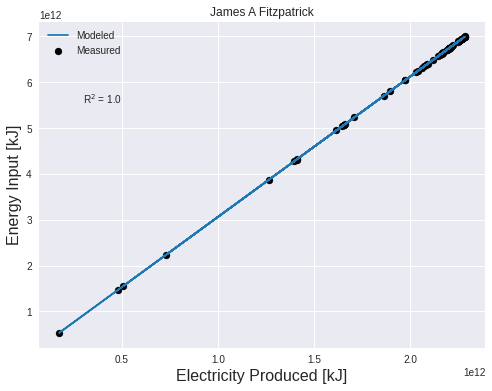

Seabrook


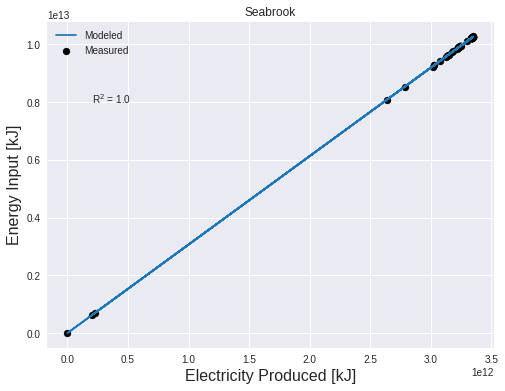

McGuire


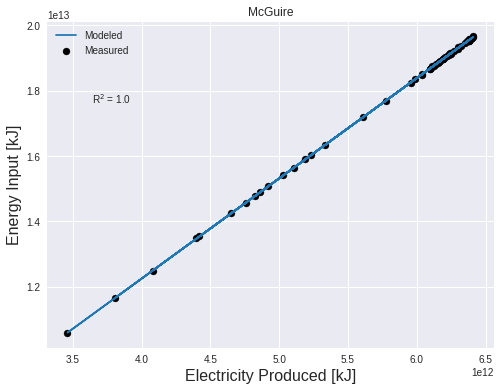

Millstone


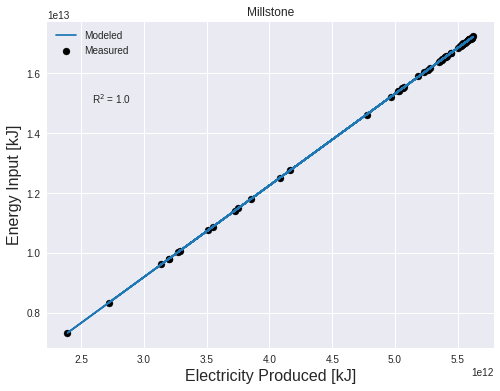

BrunswickNuclear


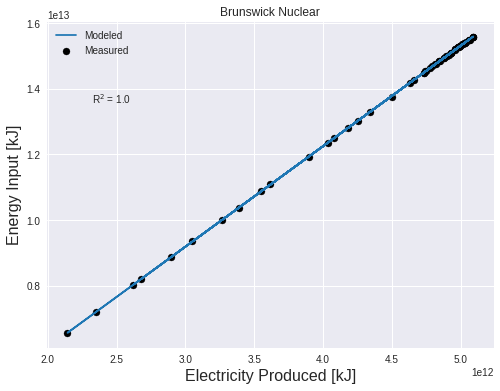

CalvertCliffsNuclearPowerPlant


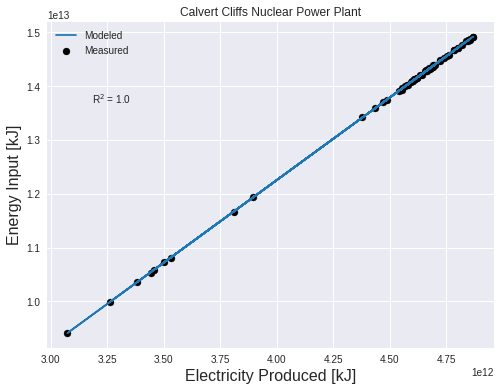

NorthAnna


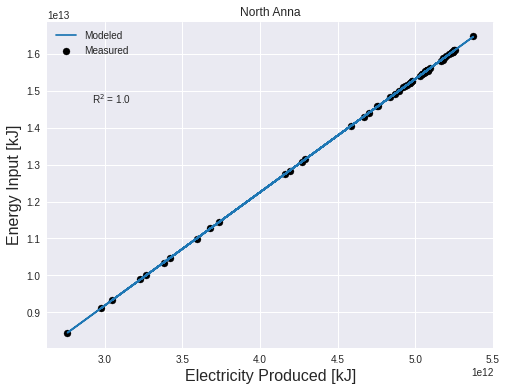

In [29]:
plant_codes = np.zeros(len(files))
plant_names = []
slopes = np.zeros(len(files))
intercepts = np.zeros(len(files))
rs_list = np.zeros(len(files))
for i,f in enumerate(files):
    # get the plant code
    code = int(f.strip('.csv').split('_')[-1])
    plant_name = eia_codes[code].replace(' ', '')
    print(plant_name)
    
    # get the plant data
    plant_df = pd.read_csv(f, index_col='date', parse_dates=True)
    plant_df = plant_df.resample('M').mean()  # only changes the dates to the last day of the month.
    
    # get the temperature data
#     temp_file = f'nrel_psm_data/{plant_name}_Temperature_2007_2020.csv'
#     temp_df = pd.read_csv(temp_file)
#     temp_df.rename(columns={'time':'date', f'Temp_{plant_name}':'air_tempC'},inplace=True)
#     temp_df.index = pd.to_datetime(temp_df.date)
#     temp_df.drop(columns='date',inplace=True)
    
#     # resample by month
#     temp_monthly = temp_df.resample('M').mean()
    
#     # combine
#     combined = plant_df.merge(temp_monthly, on='date')
    
    combined = plant_df.copy()
    # linear fit
    model = linear_fit(combined[['elc_out_kj', 'elc_in_kj']])
    
    # get parameters
    m = model.params[1]
    b = model.params[0]
    rs = model.rsquared
    
    plant_codes[i] = code
    plant_names.append(eia_codes[code])
    slopes[i] = m
    intercepts[i] = b   
    rs_list[i] = rs
    
    y_pred_uni = model.fittedvalues
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(combined.elc_out_kj, combined.elc_in_kj, label='Measured', marker='o', color='k')
    ax.plot(combined.elc_out_kj, y_pred_uni, label='Modeled', color='tab:blue')
#     ax.text(x=1,y=25,s=r'R$^2$ = {}'.format(rs), fontsize=14)
    ax.annotate(r'R$^2$ = {}'.format(round(rs,3)), xy=(.1, .75), xycoords=ax.transAxes)
    ax.legend()
    ax.set_xlabel('Electricity Produced [kJ]', fontsize=16)
    ax.set_ylabel('Energy Input [kJ]', fontsize=16)
    ax.set_title(f'{eia_codes[code]}')
    plt.show()

In [28]:
results = pd.DataFrame({'Plant ID':plant_codes,
                        'Plant Name':plant_names,
              'm':slopes,
              'b':intercepts,
              'rsquared':rs_list})
results

,Plant ID,Plant Name,m,b,rsquared
0,2589.0,Nine Mile Point Nuclear Station,3.062749,2.575186e+09,0.999973
1,3265.0,Oconee,3.061974,8.486187e+09,0.999948
2,6000.0,Donald C Cook,3.063237,2.579690e+08,0.999991
3,4046.0,Point Beach Nuclear Plant,3.063346,3.645430e+08,0.999972
4,46.0,Browns Ferry,3.059046,3.445495e+10,0.999978
5,8036.0,Cooper Nuclear Station,3.062885,6.829771e+08,0.999992
6,3806.0,Surry,3.063293,5.046076e+07,0.999978
7,6045.0,St Lucie,3.055535,3.998204e+10,0.999965
8,880.0,Quad Cities Generating Station,3.062798,2.328034e+09,0.999934
9,6099.0,Diablo Canyon,3.062560,5.965343e+09,0.999988


In [30]:
results.to_csv('linear_models/power_model.csv')